In [1]:
import math
import QUANTAXIS as QA
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
np.random.seed(107)
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS

you are using non-interactive mdoel quantaxis


## Find pairs

In [2]:
# Get etf data
code_list= QA.QA_fetch_stock_block_adv().get_block('新能源').code

In [3]:
def find_pairs(code_list, start_date, end_date, method_type):
    n = len(code_list)
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            c1 = code_list[i]
            c2 = code_list[j]
            S1 = QA.QA_fetch_stock_day_adv(c1, start_date, end_date).to_qfq().close
            S2 = QA.QA_fetch_stock_day_adv(c2, start_date, end_date).to_qfq().close
            if len(S1)!= len(S2):
                continue
            if methods[method_type](S1, S2):
                pairs.append((c1, c2))
    return pairs

In [4]:
def ed_test(x, y):
    result = coint(list(x), list(y))
    score = result[0]
    pvalue = result[1]
    if pvalue < 0.05:
        return True
    return False
    

In [5]:
def adfuller_test(x, y):
    ols = OLS(x.to_list(), y.to_list()).fit()
    adf_result = adfuller(ols.resid)
    if adf_result[0] < adf_result[4]['5%']:
        return True
    return False

In [6]:
methods = {
    'ed': ed_test,
    'adf': adfuller_test
}

In [7]:
start_date = '2019-10-01'
end_date = '2020-10-01'

In [8]:
DATA = QA.QA_fetch_stock_day_adv(code_list[:10], start_date, end_date).to_qfq()

In [9]:
pairs_ed = find_pairs(code_list[:10], start_date, end_date, 'ed')

In [10]:
pairs_adf = find_pairs(code_list[:10], start_date, end_date, 'adf')

In [11]:
pairs_ed

[('002805', '300484'),
 ('002805', '600847'),
 ('002805', '300037'),
 ('002805', '600884'),
 ('600847', '300037'),
 ('600847', '300450'),
 ('600847', '600884'),
 ('002407', '600884')]

In [12]:
pairs_adf

[('603693', '300484'), ('002805', '600847'), ('600847', '300450')]

In [98]:
code1, code2 = pairs_adf[0][0], pairs_adf[0][1]

[Text(0, 0, '2019-10-08 00:00:00'), Text(0, 0, '603693')]

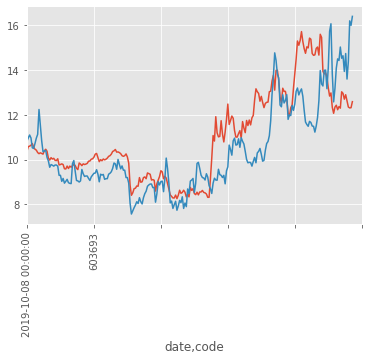

In [103]:
fig, ax = plt.subplots()
df1 = QA.QA_fetch_stock_day_adv([code1], start_date, end_date).to_qfq().close
df2 = QA.QA_fetch_stock_day_adv([code2], start_date, end_date).to_qfq().close
df1.plot(ax = ax)
df2.plot(ax = ax)

ax.set_xticks(ax.get_xticks()[::1])
ax.set_xticklabels(df1.index[0], rotation = 90)

In [104]:
def get_ratios(code_x, code_y):
    x = QA.QA_fetch_stock_day_adv(code_x, start_date, end_date).to_qfq().close
    y = QA.QA_fetch_stock_day_adv(code_y, start_date, end_date).to_qfq().close
    x.index = y.index
    return x.div(y, axis = 'index')

In [105]:
def plot_zscore(series):  
    zscores = (series - series.mean()) / np.std(series)
    zscores.plot()
    plt.axhline(zscores.mean())
    plt.axhline(1.0, color='red')
    plt.axhline(-1.0, color='green')
    plt.show()

In [106]:
ratios = get_ratios(code1, code2)

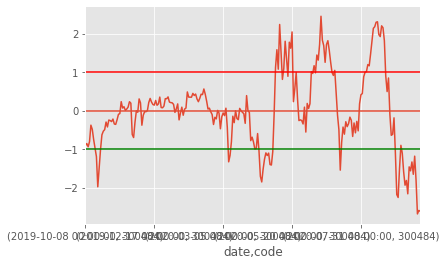

In [107]:
plot_zscore(ratios)

## Trading

In [108]:
def calc_zscore(ratios, window1, window2):
    strategy_name = 'pairs-trading'
    ma1 = ratios.rolling(window=window1,
                       center=False).mean()
    ma2 = ratios.rolling(window=window2,
                           center=False).mean()
    std = ratios.rolling(window=window2,
                    center=False).std()
    zscore = (ma1 - ma2)/std
    return zscore

In [109]:
zscores = calc_zscore(ratios, 5, 20)

In [124]:
code1 = '002805'
code2 = '300484'
## User
user = QA.QA_User(username ="admin", password="admin")
## Portfolio
port = user.new_portfolio("pair-06")
## Account
AC = port.new_account(
    strategy_name = 'pairs', 
    account_cookie = 'wtf023',
    init_cash = 200000,
#     init_hold = {code1:100000, code2:100000},
    commission_coeff = 0.00025, # 交易佣金
    tax_coeff= 0.0015, # 印花税
    market_type=QA.MARKET_TYPE.STOCK_CN,
    frequence=QA.FREQUENCE.DAY)
## Broker
Broker = QA.QA_BacktestBroker()

QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE


In [125]:
def place_order(order_code, order_time, order_amount,order_towards,market_item):
    order = AC.send_order(
                code=order_code,
                time=order_time,
                amount=order_amount,
                towards=order_towards,
                price=0,
                order_model=QA.ORDER_MODEL.CLOSE,
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
            )
    if order:
        Broker.receive_order(QA.QA_Event(order=order,market_data=market_item))
        trade_mes=Broker.query_orders(AC.account_cookie,'filled')
        res=trade_mes.loc[order.account_cookie,order.realorder_id]
        order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
    else:
        raise SystemError("place order failed")
    
    
def pairs_backtest(code1, code2):
    for i,items in enumerate(DATA.panel_gen):
        item1 = items.select_code(code1)
        item2 = items.select_code(code2)
        order_time = items.date[0]   
        if zscores[i] > 1:             
            place_order(code2,order_time, 1000, QA.ORDER_DIRECTION.BUY,item2)
            if AC.sell_available.get(item1.code[0], 0)>0:
                place_order(code1,order_time, 1000, QA.ORDER_DIRECTION.SELL,item1)   
        if zscores[i] < -1:
            if AC.sell_available.get(item2.code[0], 0)>0:
                place_order(code2,order_time, 1000, QA.ORDER_DIRECTION.SELL,item2)
            place_order(code1,order_time, 1000, QA.ORDER_DIRECTION.BUY,item1)     
        AC.settle()
    AC.save()
    risk = QA.QA_Risk(account=AC, benchmark_type=QA.MARKET_TYPE.INDEX_CN, if_fq=False)
    risk.save()

In [126]:
pairs_backtest(code1, code2)

QAACCOUNT ==> receive deal  Time 2019-11-18 00:00:00/ Code:300484/ Price:9.03/ TOWARDS:1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2019-11-19 00:00:00/ Code:300484/ Price:9.12/ TOWARDS:1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2019-11-20 00:00:00/ Code:300484/ Price:8.97/ TOWARDS:1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2019-11-21 00:00:00/ Code:300484/ Price:8.94/ TOWARDS:1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2019-11-22 00:00:00/ Code:300484/ Price:8.93/ TOWARDS:1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2020-01-13 00:00:00/ Code:300484/ Price:10.01/ TOWARDS:-1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2020-01-13 00:00:00/ Code:002805/ Price:14.26/ TOWARDS:1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2020-01-14 00:00:00/ Code:300484/ Price:9.79/ TOWARDS:-1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2020-01-14 00:00:00/ Code:002805/ Price:14.5/ TOWARDS:1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2020-01-16 00:00:00/ Code:300484/ Pr

In [24]:
risk = QA.QA_Risk(account=AC, benchmark_type=QA.MARKET_TYPE.INDEX_CN, if_fq=False)
risk.save()

贝塔计算错误。。
贝塔计算错误。。


In [ ]:
QA.QA_Risk(AC).message

In [ ]:
AC.history_table

贝塔计算错误。。
贝塔计算错误。。


/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
Th

[]

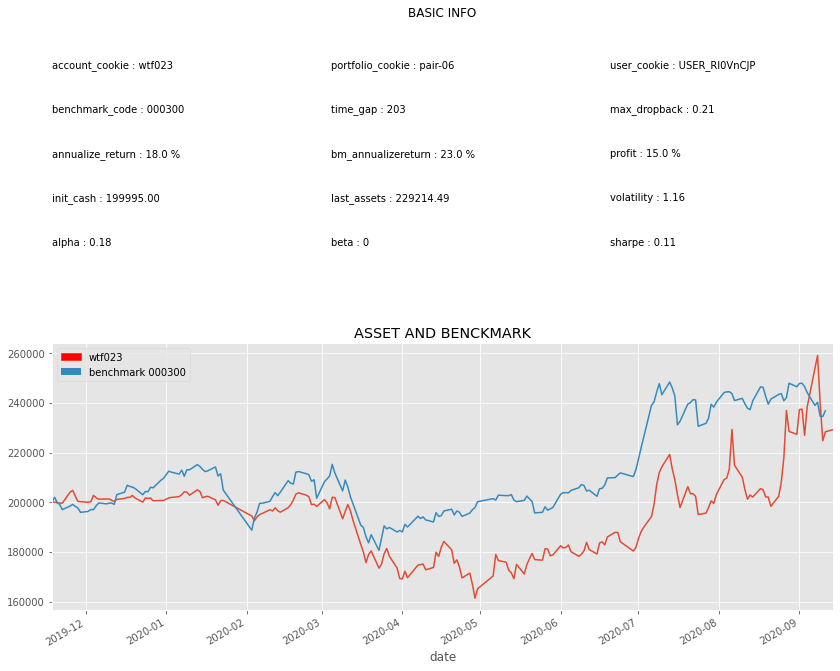

In [127]:
# 新能车 399417
risk = QA.QA_Risk(account=AC, benchmark_code="000300", benchmark_type=QA.MARKET_TYPE.INDEX_CN, if_fq=False)
risk.save()
# print(risk.message)
fig=risk.plot_assets_curve()
fig.plot()

In [28]:
performance = QA.QA_Performance(AC)

In [29]:
performance.pnl

,sell_date,buy_date,amount,sell_price,buy_price,rawdirection,unit,pnl_ratio,pnl_money,hold_gap,if_buyopen,openprice,opendate,closeprice,closedate
code,,,,,,,,,,,,,,,
300484,2020-01-13,2019-11-18,1000.0,10.01,9.03,buy,1.0,0.108527,980.0,56 days,True,9.03,2019-11-18 00:00:00,10.01,2020-01-13 00:00:00
300484,2020-01-14,2019-11-19,1000.0,9.79,9.12,buy,1.0,0.073465,670.0,56 days,True,9.12,2019-11-19 00:00:00,9.79,2020-01-14 00:00:00
300484,2020-01-16,2019-11-20,1000.0,9.72,8.97,buy,1.0,0.083612,750.0,57 days,True,8.97,2019-11-20 00:00:00,9.72,2020-01-16 00:00:00
300484,2020-01-17,2019-11-21,1000.0,9.53,8.94,buy,1.0,0.065996,590.0,57 days,True,8.94,2019-11-21 00:00:00,9.53,2020-01-17 00:00:00
603693,2020-02-04,2020-01-13,1000.0,8.41,10.35,buy,1.0,-0.187440,-1940.0,22 days,True,10.35,2020-01-13 00:00:00,8.41,2020-02-04 00:00:00
603693,2020-02-05,2020-01-14,1000.0,8.52,10.32,buy,1.0,-0.174419,-1800.0,22 days,True,10.32,2020-01-14 00:00:00,8.52,2020-02-05 00:00:00
603693,2020-02-06,2020-01-16,1000.0,8.70,10.18,buy,1.0,-0.145383,-1480.0,21 days,True,10.18,2020-01-16 00:00:00,8.70,2020-02-06 00:00:00
300484,2020-02-24,2019-11-22,1000.0,8.91,8.93,buy,1.0,-0.002240,-20.0,94 days,True,8.93,2019-11-22 00:00:00,8.91,2020-02-24 00:00:00
300484,2020-02-25,2020-02-04,1000.0,8.91,7.57,buy,1.0,0.177015,1340.0,21 days,True,7.57,2020-02-04 00:00:00,8.91,2020-02-25 00:00:00


In [30]:
performance.message

{'total_profit': 321510.0,
 'total_loss': -59460.0,
 'total_pnl': 5.41,
 'trading_amounts': 130,
 'profit_amounts': 102,
 'loss_amounts': 28,
 'even_amounts': 0,
 'profit_precentage': 0.78,
 'loss_precentage': 0.22,
 'even_precentage': 0.0,
 'average_profit': 3152.06,
 'average_loss': -2123.57,
 'average_pnl': 1.48,
 'max_profit': 7160.0,
 'max_loss': -5130.0,
 'max_pnl': 1.4,
 'netprofio_maxloss_ratio': 51.08,
 'continue_profit_amount': 53,
 'continue_loss_amount': 17,
 'average_holdgap': '83 days 21:13:50.769230',
 'average_profitholdgap': '66 days 22:49:24.705882',
 'average_losssholdgap': '145 days 13:42:51.428571',
 'buyopen': {'total_profit': 321510.0,
  'total_loss': -59460.0,
  'total_pnl': 5.41,
  'trading_amounts': 130,
  'profit_amounts': 102,
  'loss_amounts': 28,
  'even_amounts': 0,
  'profit_precentage': 0.78,
  'loss_precentage': 0.22,
  'even_precentage': 0.0,
  'average_profit': 3152.06,
  'average_loss': -2123.57,
  'average_pnl': 1.48,
  'max_profit': 7160.0,
  'max